In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from func import*
from vnstock import *

In [2]:
close = pd.read_csv("vn_price.csv", index_col="TradingDate", parse_dates=True)

In [3]:
a=Stochastic_simulation(close)

## a) Tính chuỗi dữ liệu về Tỷ suất lợi nhuận theo phương pháp liên tục

In [4]:
a.returns

,AAA,AAM,AAT,ABR,ABS,ABT,ACB,ACC,ACG,ACL,...,VPS,VRC,VRE,VSC,VSH,VSI,VTB,VTO,YBM,YEG
TradingDate,,,,,,,,,,,,,,,,,,,,,
2013-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-26,-0.040350,0.004058,NaN,NaN,NaN,-0.026732,-0.017808,0.011172,NaN,-0.025098,...,NaN,-0.056566,NaN,-0.067702,-0.058754,0.058069,-0.048910,-0.054743,NaN,NaN
2013-02-27,0.000000,-0.008179,NaN,NaN,NaN,0.002512,0.005873,0.000000,NaN,0.000000,...,NaN,-0.039884,NaN,0.022489,-0.008937,0.000000,-0.051131,0.019452,NaN,NaN
2013-02-28,0.013931,0.000000,NaN,NaN,NaN,0.002450,0.000000,0.000000,NaN,0.008582,...,NaN,0.000000,NaN,0.004869,0.018036,0.000000,0.067513,0.018647,NaN,NaN
2013-03-01,-0.006745,0.000000,NaN,NaN,NaN,0.019942,0.006093,0.000000,NaN,0.000000,...,NaN,0.062448,NaN,0.000000,0.017716,0.000000,-0.038004,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-24,-0.013590,0.000000,0.001969,0.000000,-0.008475,-0.009642,-0.031496,0.014085,-0.028777,0.007968,...,-0.032222,0.058511,0.000000,-0.012739,0.007792,0.000000,0.000000,-0.002439,-0.020134,-0.061947
2023-02-27,-0.001148,0.000000,-0.019646,-0.004785,-0.008547,-0.069541,-0.014228,-0.003472,0.000000,-0.039526,...,0.000000,-0.069347,-0.028302,-0.032258,-0.003866,0.000000,-0.066667,-0.011002,-0.001712,-0.056604
2023-02-28,-0.001149,-0.034632,0.000000,0.000000,-0.013793,0.068759,0.006186,-0.010453,0.022222,-0.004115,...,-0.009185,-0.007559,0.036893,-0.001667,0.001294,0.000000,0.000000,0.000000,-0.063465,0.040000


## b) Lấy thông tin về Thống kê mô tả của hai chuỗi Tỷ suất lợi nhuận nói trên trong Excel

In [5]:
a.describe_returns()

,AAA,AAM,AAT,ABR,ABS,ABT,ACB,ACC,ACG,ACL,...,VPS,VRC,VRE,VSC,VSH,VSI,VTB,VTO,YBM,YEG
count,2501.000000,2501.000000,484.000000,1181.000000,739.000000,2501.000000,2501.000000,2501.000000,392.000000,2501.000000,...,1885.000000,2501.000000,1328.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,1131.000000,1171.000000
mean,0.000620,0.000454,-0.001059,0.001388,0.000087,0.000572,0.000898,0.000782,-0.001314,0.000809,...,0.000571,0.000837,0.000158,0.000833,0.000824,0.001236,0.000972,0.000764,-0.000183,-0.002197
std,0.024719,0.029025,0.029814,0.053771,0.037979,0.024194,0.017991,0.023577,0.018309,0.027265,...,0.033184,0.032660,0.024626,0.020745,0.018238,0.032286,0.031333,0.021712,0.031328,0.035915
min,-0.100094,-0.069979,-0.070000,-0.400000,-0.070000,-0.081869,-0.098149,-0.069936,-0.069745,-0.069968,...,-0.070042,-0.070000,-0.069767,-0.070020,-0.070000,-0.070031,-0.069973,-0.069905,-0.070103,-0.070000
25%,-0.011696,-0.012931,-0.016714,0.000000,-0.022222,-0.006840,-0.006476,-0.006727,-0.006086,-0.010553,...,-0.010139,-0.015441,-0.012205,-0.009518,-0.006380,-0.011201,-0.012308,-0.010383,-0.013890,-0.019959
50%,0.000000,0.000000,-0.003398,0.000000,0.002525,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001733
75%,0.012048,0.013067,0.012450,0.000000,0.020534,0.008189,0.008016,0.009623,0.004994,0.010998,...,0.012816,0.016654,0.011730,0.009623,0.006972,0.013740,0.016685,0.010965,0.012871,0.014171
max,0.100017,0.070044,0.109916,0.166667,0.070042,0.072416,0.096994,0.113702,0.077266,0.069914,...,0.069993,0.070000,0.070000,0.069869,0.069959,0.069991,0.069977,0.070254,0.070022,0.070000


## c) Lập danh mục đầu tư hai cổ phiếu với Tỷ trọng thay đổi.  Tính Tỷ suất lợi nhuận của danh mục theo hai cách : trực tiếp và gián tiếp.

Danh mục

In [6]:
weights = a.close.div(a.close.abs().sum(axis=1), axis=0).shift(1)
weights

,AAA,AAM,AAT,ABR,ABS,ABT,ACB,ACC,ACG,ACL,...,VPS,VRC,VRE,VSC,VSH,VSI,VTB,VTO,YBM,YEG
TradingDate,,,,,,,,,,,,,,,,,,,,,
2013-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-26,0.002072,0.005213,NaN,NaN,NaN,0.009270,0.002008,0.002029,NaN,0.002047,...,NaN,0.002021,NaN,0.003147,0.003832,0.001414,0.001802,0.001205,NaN,NaN
2013-02-27,0.002045,0.005385,NaN,NaN,NaN,0.009281,0.002029,0.002110,NaN,0.002053,...,NaN,0.001962,NaN,0.003018,0.003710,0.001539,0.001763,0.001172,NaN,NaN
2013-02-28,0.002040,0.005325,NaN,NaN,NaN,0.009277,0.002035,0.002104,NaN,0.002047,...,NaN,0.001878,NaN,0.003077,0.003666,0.001534,0.001668,0.001191,NaN,NaN
2013-03-01,0.002047,0.005271,NaN,NaN,NaN,0.009205,0.002014,0.002083,NaN,0.002043,...,NaN,0.001859,NaN,0.003060,0.003694,0.001519,0.001763,0.001201,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-24,0.000911,0.001191,0.000524,0.001078,0.000609,0.003744,0.002620,0.001465,0.004301,0.001294,...,0.000928,0.000970,0.002733,0.003239,0.003971,0.001753,0.001315,0.000846,0.000615,0.001166
2023-02-27,0.000905,0.001200,0.000529,0.001086,0.000608,0.003735,0.002556,0.001496,0.004208,0.001314,...,0.000905,0.001034,0.002754,0.003221,0.004032,0.001766,0.001325,0.000850,0.000607,0.001101
2023-02-28,0.000914,0.001213,0.000524,0.001093,0.000609,0.003514,0.002548,0.001508,0.004255,0.001276,...,0.000915,0.000973,0.002705,0.003152,0.004061,0.001786,0.001250,0.000850,0.000612,0.001051


In [7]:
ti_suat_danh_muc = np.sum(weights*a.returns,axis=1)

In [8]:
px.line(np.cumsum(ti_suat_danh_muc),title='PnL')

## d) Kiểm chứng tính chuẩn của Tỷ suất lợi nhuận các cổ phiếu và danh mục.

In [9]:
a.test_for_normal()

,jb_value,p_value
TDM,7601.578078,0.000000
BHN,2292.607553,0.000000
SBA,2542.334164,0.000000
ICT,4426.395575,0.000000
IBC,17807.912606,0.000000
...,...,...
KHG,0.442581,0.801484
HTL,0.353947,0.837802
HVX,0.269852,0.873781
NAV,0.215010,0.898072


In [10]:
from scipy.stats import jarque_bera
jb_value_port, p_value_port = jarque_bera(ti_suat_danh_muc)
print(f"Portfolio p_value: {p_value_port}")

Portfolio p_value: 0.0


In [11]:
a.plot_box_returns(['HU1','TDM'])

<Axes: ylabel='Density'>

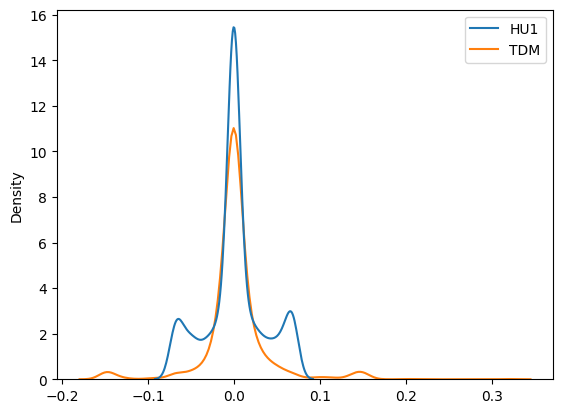

In [12]:
sns.kdeplot(a.returns[['HU1','TDM']])

## e) Giả sử có một trong 3 chuỗi trên phân phối chuẩn hãy viết Phương trình động thái giá (hoặc danh mục) theo mô hình chuyển động Brown hình học.

Giả sử mô hình chuyển động của giá là $S(t)=S(0)e^{\sigma B_t+(\mu-\frac12 \sigma^2)t}$
#### Ước lượng $\mu$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr E(r)=E(\frac{dS_t}{S_t})=E(\mu dt+\sigma dB_t)\\
&\Rarr E(r)=E(\mu dt)+E(\sigma dB_t)\\
&\Rarr E(r)=\mu E(dt)\\
&\Rarr \frac{E(r)}{dt}=\mu
\end{aligned}
$$

#### Ước lượng $\sigma$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr V(r)=V(\frac{dS_t}{S_t})=V(\mu dt+\sigma dB_t)\\
&\Rarr V(r)=V(\mu dt)+V(\sigma dB_t)\\
&\Rarr V(r)=\sigma^2 \times dt\\
&\Rarr \sqrt{\frac{V(r)}{dt}}=\sigma
\end{aligned}
$$

In [13]:
a.plot_price_simulation('YEG')

mu: -2.5750153288393403
sigma: 1.229541343344382


In [14]:
a.plot_price_simulation('FPT')

mu: 2.7811755125754893
sigma: 0.8093221452273478


In [17]:
musig=a.get_mu_sigma()
musig['sharpe']=musig.muy/musig.sigma
musig.sort_values('sharpe',ascending=False)

,muy,sigma,sharpe
FIR,2.486103,0.511727,4.858260
GAB,2.827109,0.649179,4.354898
DHC,3.964234,1.086705,3.647939
THG,4.128489,1.186703,3.478959
FPT,2.781176,0.809322,3.436426
...,...,...,...
DXS,-1.030306,0.701875,-1.467934
GMH,-0.725013,0.479583,-1.511758
APH,-1.163855,0.759516,-1.532364
SVD,-1.256902,0.695400,-1.807451


In [18]:
a.plot_price_simulation('FIR')

mu: 2.486103015563958
sigma: 0.5117270902471013
